#### imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                                roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, 
                                    precision_recall_curve, classification_report)

#### Functions

In [2]:
global scores
scores = {}

def model_score(model_name, y_true, y_pred):
    scores[model_name] = {  "precession_score" : precision_score(y_true, y_pred), 
                            "recall_score" : recall_score(y_true, y_pred), 
                            "f1_score" : f1_score(y_true, y_pred)}

In [3]:
def metric_scores(actual, pred, data_type):
    print("-" * 70)
    print(f"{data_type} data results:")
    print(f"  accuracy_score = {accuracy_score(actual, pred)}")  
    print(f"  precision_score = {precision_score(actual, pred)}") 
    print(f"  recall_score = {recall_score(actual, pred)}") 
    print(f"  f1_score = {f1_score(actual, pred)}") 
    
    if data_type == "test":  
        print(f"  roc_auc_score = {roc_auc_score(actual, pred)}")
        print("  Classification Report")
        print(f"{classification_report(actual, pred)}\n")
        print(f"  Confusion Matrix")
        conf = confusion_matrix(actual, pred)
        ConfusionMatrixDisplay(conf).plot()

In [4]:
def grid_search_cv(model, param_grid, scoring, X_train, y_train, folds):

    k_fold = KFold(n_splits = folds, shuffle = True, random_state = random_seed)

    grid_search = GridSearchCV(model, param_grid, cv = k_fold, scoring = scoring, n_jobs = -1, verbose = 1) 
    grid_search.fit(X_train, y_train)
    
    print(f"best params = {grid_search.best_params_}")

    return grid_search.best_estimator_ 

#### Model

In [5]:
random_seed = 42

In [6]:
df = pd.read_csv("data.csv")
df.head()

,Income_mean,Income_last,Total Business Value_sum,Total Business Value_min,Total Business Value_max,Total Business Value_mean,Total Business Value_last,City_last,Education_Level_last,Joining Designation_last,...,Grade_max,Grade_mean,Grade_last,Quarterly Rating_max,Gender_last,churn,rating_change,income_change,days_worked,current_month
0,57387.0,57387.0,1715580.0,-665480.0,2381060.0,571860.0,0.0,23,2.0,1.0,...,1.0,1.0,1.0,2.0,0.0,1,0,0,68,3
1,67016.0,67016.0,0.0,0.0,0.0,0.0,0.0,7,2.0,2.0,...,2.0,2.0,2.0,1.0,0.0,0,0,0,26,12
2,65603.0,65603.0,350000.0,0.0,350000.0,70000.0,0.0,13,2.0,2.0,...,2.0,2.0,2.0,1.0,0.0,1,0,0,117,4
3,46368.0,46368.0,120360.0,0.0,120360.0,40120.0,0.0,9,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1,0,0,52,3
4,78728.0,78728.0,1265000.0,0.0,1265000.0,253000.0,0.0,11,1.0,3.0,...,3.0,3.0,3.0,2.0,1.0,0,1,0,124,12


In [7]:
X = df.drop("churn", axis = 1).copy()
y = df.churn.copy()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = random_seed)

print(f"shape of the data ")
print("train: ")
print(f"  X_train = {X_train.shape}")
print(f"  y_train = {y_train.shape}")

print("test: ")
print(f"  X_test = {X_test.shape}")
print(f"  y_test = {y_test.shape}")


shape of the data 
train: 
  X_train = (1903, 21)
  y_train = (1903,)
test: 
  X_test = (476, 21)
  y_test = (476,)


In [9]:
cols = [col for col in X_train.columns if df[col].nunique() <= 30 or df[col].dtype == "O"]
te = TargetEncoder(cols = cols)
te.fit(X_train, y_train)

X_train = te.transform(X_train)
X_test = te.transform(X_test)

##### Logistic Regression - Model

oversampling the minor class

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sca = scaler.transform(X_train)
X_test_sca = scaler.transform(X_test)

In [11]:
(y_train.value_counts() )

churn
1    1287
0     616
Name: count, dtype: int64

In [12]:
smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X_train_sca, y_train)
y_sm.value_counts()

churn
0    1287
1    1287
Name: count, dtype: int64

In [13]:
logreg = LogisticRegression()
logreg.fit(X_sm, y_sm)

LogisticRegression()

Scores for logistic regression model - OverSampled
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9397824397824398
  precision_score = 0.9685430463576159
  recall_score = 0.9090909090909091
  f1_score = 0.937875751503006
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.930672268907563
  precision_score = 0.9737704918032787
  recall_score = 0.922360248447205
  f1_score = 0.9473684210526316
  roc_auc_score = 0.9352060982495765
  Classification Report
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       154
           1       0.97      0.92      0.95       322

    accuracy                           0.93       476
   macro avg       0.91      0.94      0.92       476
weighted avg       0.93      0.93      0.93       476


  Confusion Matrix


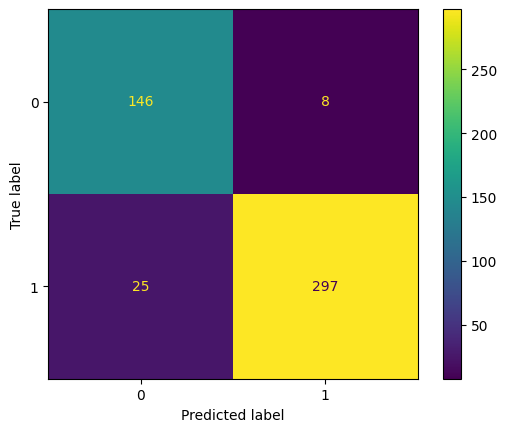

In [15]:
print(f"Scores for logistic regression model - OverSampled")
metric_scores(y_sm, logreg.predict(X_sm), data_type = "train")
metric_scores(y_test, logreg.predict(X_test_sca), data_type = "test")

with no oversampling in data

In [16]:
logreg1 = LogisticRegression()
logreg1.fit(X_train_sca, y_train)

LogisticRegression()

Scores for logistic regression model - Basic
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.928008407777194
  precision_score = 0.9791666666666666
  recall_score = 0.912975912975913
  f1_score = 0.9449135504624046
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.9327731092436975
  precision_score = 0.9738562091503268
  recall_score = 0.9254658385093167
  f1_score = 0.9490445859872612
  roc_auc_score = 0.9367588932806323
  Classification Report
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       154
           1       0.97      0.93      0.95       322

    accuracy                           0.93       476
   macro avg       0.92      0.94      0.93       476
weighted avg       0.94      0.93      0.93       476


  Confusion Matrix


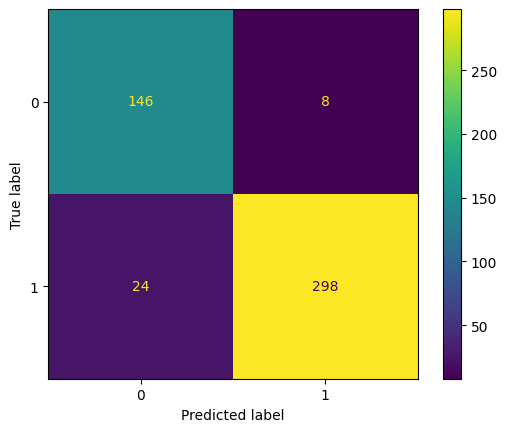

In [17]:
print(f"Scores for logistic regression model - Basic")
metric_scores(y_train, logreg1.predict(X_train_sca), data_type = "train")
metric_scores(y_test, logreg1.predict(X_test_sca), data_type = "test")

There is no much difference with respect to oversampling, this maybe due to the ratio between the majority to minority class being 67:33 (not so much dominating class), but we know logistic regression is impacted by imbalance in data. So, let's hypertune the model with oversampled data

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


best params = {'C': 450.001}
Scores for logistic regression model (hyper parameters tuned)
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9405594405594405
  precision_score = 0.968595041322314
  recall_score = 0.9106449106449106
  f1_score = 0.9387264717661192
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.9243697478991597
  precision_score = 0.9673202614379085
  recall_score = 0.9192546583850931
  f1_score = 0.9426751592356687
  roc_auc_score = 0.927159796725014
  Classification Report
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       154
           1       0.97      0.92      0.94       322

    accuracy                           0.92       476
   macro avg       0.91      0.93      0.92       476
weighted avg       0.93      0.92      0.93       476


  Confusion Matrix


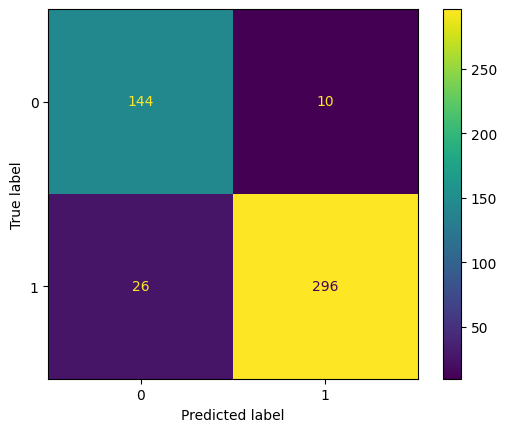

In [18]:
c_values = np.arange(0.001, 1200, 10)

param_grid = dict(C = c_values)

logreg2 = grid_search_cv(LogisticRegression(random_state = random_seed, max_iter = 1000), param_grid, "f1", X_sm, y_sm, folds = 10)
logreg2.fit(X_sm, y_sm)

print(f"Scores for logistic regression model (hyper parameters tuned)")
metric_scores(y_sm, logreg2.predict(X_sm), data_type = "train")
metric_scores(y_test, logreg2.predict(X_test_sca), data_type = "test")

# best params = {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}

In [19]:
scores["LogisticRegression"] = {"oversampling" : roc_auc_score(y_test, logreg1.predict(X_test_sca)),
                                    "sampling" : roc_auc_score(y_test, logreg2.predict(X_test_sca))}

#### Decision Tree

with no oversampling

Fitting 5 folds for each of 10192 candidates, totalling 50960 fits
best params = {'ccp_alpha': 0.0001, 'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 20, 'min_samples_leaf': 20}

Scores for Decision Tree Classifier model (hyper parameters tuned)
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9264319495533369
  precision_score = 0.980720871751886
  recall_score = 0.9090909090909091
  f1_score = 0.9435483870967741
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.930672268907563
  precision_score = 0.976897689768977
  recall_score = 0.9192546583850931
  f1_score = 0.9472
  roc_auc_score = 0.9369000564652739
  Classification Report
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       154
           1       0.98      0.92      0.95       322

    accuracy                        

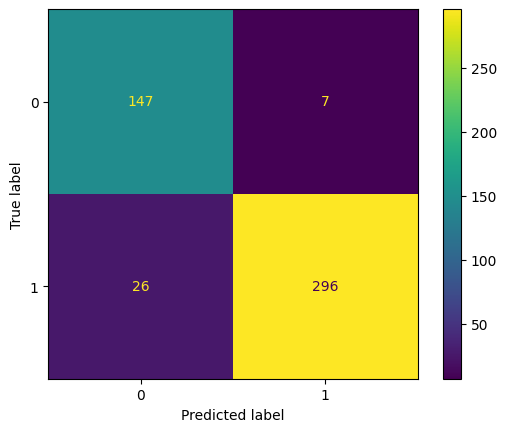

In [20]:
criterion = ["gini", "log_loss"]
max_depth = [_ for _ in range(5,70,5)]
max_features = ["sqrt", "log2"]
max_leaf_nodes = [_ for _ in range(10,80,10)]
min_samples_leaf = [_ for _ in range(2,21,3)]
ccp_alpha = [0.0001,0.001,0.1,1]

param_grid = dict(criterion = criterion, max_depth = max_depth, ccp_alpha = ccp_alpha, max_features = max_features, max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf)

decisionTreeClassifier1 = grid_search_cv(DecisionTreeClassifier(random_state = random_seed, splitter = "best", class_weight = "balanced"), param_grid, "f1", X_train, y_train, folds = 5)
decisionTreeClassifier1.fit(X_train, y_train)

print(f"\nScores for Decision Tree Classifier model (hyper parameters tuned)")
metric_scores(y_train, decisionTreeClassifier1.predict(X_train), data_type = "train")
metric_scores(y_test, decisionTreeClassifier1.predict(X_test), data_type = "test")

# best params = {'ccp_alpha': 0.0001, 'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 20, 'min_samples_leaf': 20}

with oversampling

In [21]:
smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X_train, y_train)
y_sm.value_counts()

churn
0    1287
1    1287
Name: count, dtype: int64

Fitting 5 folds for each of 10192 candidates, totalling 50960 fits


best params = {'ccp_alpha': 0.0001, 'criterion': 'log_loss', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': 20, 'min_samples_leaf': 17}

Scores for Decision Tree Classifier model (hyper parameters tuned) - OverSampled
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9506604506604507
  precision_score = 0.9723127035830619
  recall_score = 0.9277389277389277
  f1_score = 0.9495029821073558
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.9222689075630253
  precision_score = 0.9552715654952076
  recall_score = 0.9285714285714286
  f1_score = 0.941732283464567
  roc_auc_score = 0.9188311688311689
  Classification Report
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       154
           1       0.96      0.93      0.94       322

    accuracy                           0.92       476
   macro avg       0.9

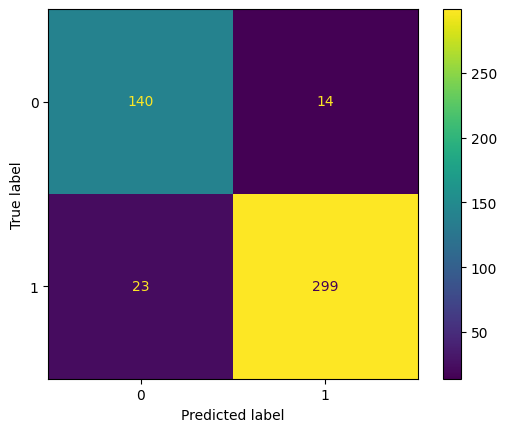

In [22]:
decisionTreeClassifier2 = grid_search_cv(DecisionTreeClassifier(random_state = random_seed, splitter = "best", class_weight = "balanced"), param_grid, "f1", X_sm, y_sm, folds = 5)
decisionTreeClassifier2.fit(X_sm, y_sm)

print(f"\nScores for Decision Tree Classifier model (hyper parameters tuned) - OverSampled")
metric_scores(y_sm, decisionTreeClassifier2.predict(X_sm), data_type = "train")
metric_scores(y_test, decisionTreeClassifier2.predict(X_test), data_type = "test")

# best params = {'ccp_alpha': 0.0001, 'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 40, 'min_samples_leaf': 14}

In [23]:
scores["DecisonTreeClassifier"] = {"oversampling" : roc_auc_score(y_test, decisionTreeClassifier2.predict(X_test)),
                                    "sampling" : roc_auc_score(y_test, decisionTreeClassifier1.predict(X_test))}

#### RandomForestClassifier - Bagging

with no oversampling

In [34]:
grid = {
 "n_estimators":[val for val in range (100,1000, 100)],
 "max_depth" : [val for val in range (3,20)],
#  "min_samples_split" : [_ for _ in range(2,21,3)],
#  "min_samples_leaf" : [_ for _ in range(2,21,3)], 
 "bootstrap" : [True],
 "ccp_alpha" : [.1, .01, .001,.0001]
}

rfc_model1 = grid_search_cv(RandomForestClassifier(random_state = random_seed, class_weight = "balanced", n_jobs = -1), grid, "f1", X_train, y_train, folds = 5)
rfc_model1.fit(X_train, y_train)

# best params = {'bootstrap': True, 'ccp_alpha': 0.001, 'max_depth': 17, 'n_estimators': 700}

Fitting 5 folds for each of 612 candidates, totalling 3060 fits
best params = {'bootstrap': True, 'ccp_alpha': 0.001, 'max_depth': 17, 'n_estimators': 700}


RandomForestClassifier(ccp_alpha=0.001, class_weight='balanced', max_depth=17,
                       n_estimators=700, n_jobs=-1, random_state=42)


Scores for RandomForest Classifier model (hyper parameters tuned) - no OverSampling
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9705727798213347
  precision_score = 0.9920063948840927
  recall_score = 0.9642579642579643
  f1_score = 0.9779353821907013
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.9327731092436975
  precision_score = 0.9617834394904459
  recall_score = 0.937888198757764
  f1_score = 0.949685534591195
  roc_auc_score = 0.9299830604178431
  Classification Report
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       154
           1       0.96      0.94      0.95       322

    accuracy                           0.93       476
   macro avg       0.92      0.93      0.92       476
weighted avg       0.93      0.93      0.93       476


  Confusion Matrix


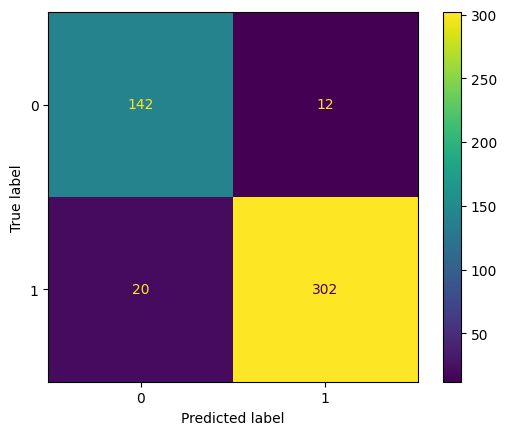

In [35]:
print(f"\nScores for RandomForest Classifier model (hyper parameters tuned) - no OverSampling")
metric_scores(y_train, rfc_model1.predict(X_train), data_type = "train")
metric_scores(y_test, rfc_model1.predict(X_test), data_type = "test")

In [36]:
rfc_model2 = grid_search_cv(RandomForestClassifier(random_state = random_seed, class_weight = "balanced_subsample", n_jobs = -1), grid, "f1", X_sm, y_sm, folds = 5)
rfc_model2.fit(X_sm, y_sm)

# best params = {'bootstrap': True, 'ccp_alpha': 0.001, 'max_depth': 17, 'n_estimators': 700}

Fitting 5 folds for each of 612 candidates, totalling 3060 fits


KeyboardInterrupt: 